In [120]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230704_Axial_z2_Data'
dataname = data+'_Raw'+'072903'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:12]
SensorData1 = SD1

In [121]:
SD1.sample(5)

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
4854,39.0,41.0,48.0,42.0,42.0,30.0,49.0,35.74,66.88,2,0,5.6
9612,41.0,46.0,43.0,38.0,45.0,37.0,49.0,16.65,545.36,6,0,3.2
31231,38.0,46.0,47.0,34.0,46.0,46.0,37.0,112.06,1246.99,20,0,7.2
46024,43.0,41.0,44.0,38.0,41.0,38.0,40.0,127.16,849.11,30,0,8.0
1171,37.0,47.0,48.0,41.0,44.0,44.0,50.0,15.85,-98.26,0,0,4.0


In [122]:
# data = '230703_Axial_z2_Data_2'
# dataname = data+'_02'
# filename = 'myData/'+data+'.csv'
# SD2 = pd.read_csv(filename)
# SD2=SD2.iloc[:,:28]
# SensorData2 = SD2
# SD2['z'] += 550
# SD2['z'] /= 5
# SD2

In [123]:
# SDreal = pd.concat([SD1, SD2])

In [124]:
SDreal = SD1

In [125]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,202131.000000,202095.000000,202080.000000,202151.000000,202090.000000,202079.000000,202115.000000,202259.000000,202259.000000,202259.000000,202259.0,202259.000000
mean,42.754535,44.259789,48.249025,39.070789,43.258118,41.886005,49.292215,74.761637,-3206.817161,69.618202,0.0,4.791089
std,68.031985,104.297951,94.394885,79.269768,68.043460,87.230449,104.235657,67.992472,3845.800704,40.996144,0.0,2.064388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,-483.760000,-11501.980000,0.000000,0.0,1.600000
25%,40.000000,40.000000,44.000000,36.000000,40.000000,37.000000,46.000000,36.460000,-5916.270000,34.000000,0.0,3.200000
50%,42.000000,43.000000,47.000000,38.000000,43.000000,40.000000,49.000000,72.720000,-2402.310000,70.000000,0.0,4.800000
75%,44.000000,45.000000,49.000000,41.000000,45.000000,45.000000,51.000000,110.960000,421.700000,106.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,9998.550000,1642.320000,140.000000,0.0,8.000000


In [126]:
# SDreal 값이 0보다 작은데 encoder 인 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]
SDreal = SDreal[~((SDreal['z'] % 2 == 0) & (SDreal['z'] % 4 != 0))]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 100)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal <= -300) & (SDreal.columns == "Force")).any(axis=1)]

SDreal = SDreal[SDreal["r"] >= 0.8*3]
SDreal = SDreal[SDreal["z"] <= 130]
SDreal = SDreal[SDreal["z"] >= 30]
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.000000,54797.0,54797.000000
mean,42.328613,41.920543,45.442707,37.243590,42.281968,40.839991,48.445371,97.399887,-3714.870602,79.840940,0.0,5.593970
std,2.831889,4.212783,3.603925,3.631315,3.825006,4.802937,3.670711,30.749440,3012.749315,28.862415,0.0,1.599174
min,14.000000,14.000000,11.000000,20.000000,6.000000,11.000000,19.000000,43.290000,-9878.200000,32.000000,0.0,3.200000
25%,41.000000,39.000000,43.000000,35.000000,40.000000,37.000000,47.000000,70.290000,-5878.920000,56.000000,0.0,4.000000
50%,42.000000,42.000000,46.000000,37.000000,43.000000,40.000000,49.000000,97.110000,-4060.810000,80.000000,0.0,5.600000
75%,44.000000,45.000000,48.000000,40.000000,45.000000,44.000000,51.000000,126.960000,-749.970000,104.000000,0.0,7.200000
max,56.000000,56.000000,77.000000,57.000000,75.000000,56.000000,69.000000,170.810000,840.230000,128.000000,0.0,8.000000


In [127]:
def normalize_dataframe(df, columns):
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / (df[column].max() - df[column].min()) * 2
    return df


#SDreal_normalized = normalize_dataframe(SDreal)
SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force', 'z'])
SDreal = SDreal_normalized
SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
46750,45.0,50.0,45.0,41.0,39.0,44.0,46.0,-0.697771,840.23,-0.996686,0,-0.997488
46751,38.0,48.0,45.0,41.0,43.0,45.0,49.0,-0.695105,839.97,-0.996686,0,-0.997488
46752,38.0,48.0,45.0,39.0,43.0,45.0,49.0,-0.695105,839.79,-0.996686,0,-0.997488
46753,38.0,48.0,45.0,39.0,43.0,45.0,47.0,-0.697771,839.71,-0.996686,0,-0.997488
46754,39.0,46.0,45.0,40.0,43.0,41.0,47.0,-0.697614,839.62,-0.996686,0,-0.997488
...,...,...,...,...,...,...,...,...,...,...,...,...
185438,34.0,34.0,50.0,39.0,41.0,42.0,51.0,0.457499,-9877.59,1.003314,0,1.002512
185439,34.0,34.0,49.0,39.0,42.0,42.0,51.0,0.456558,-9877.24,1.003314,0,1.002512
185440,34.0,37.0,49.0,39.0,42.0,40.0,51.0,0.456244,-9877.41,1.003314,0,1.002512
185441,34.0,37.0,43.0,39.0,42.0,40.0,51.0,0.456087,-9877.76,1.003314,0,1.002512


In [128]:
SDy = SDreal.iloc[:,[7,9]]
SDy.describe()

,Force,z
count,5.479700e+04,5.479700e+04
mean,-2.247297e-14,-9.425696e-14
std,4.822685e-01,6.013003e-01
min,-8.486494e-01,-9.966863e-01
25%,-4.251864e-01,-4.966863e-01
50%,-4.546532e-03,3.313746e-03
75%,4.636153e-01,5.033137e-01
max,1.151351e+00,1.003314e+00


In [129]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# SDreal.hist(bins=50, figsize=(20,15))
# plt.savefig('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/SensorCallbi/LABS_v3/savefig/'+dataname+'_hist230320.png')
# plt.show()

In [130]:
X = SDreal.iloc[:,:7]
y = SDreal.iloc[:,[7,9]]

In [131]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06
46750,45.0,50.0,45.0,41.0,39.0,44.0,46.0
46751,38.0,48.0,45.0,41.0,43.0,45.0,49.0
46752,38.0,48.0,45.0,39.0,43.0,45.0,49.0
46753,38.0,48.0,45.0,39.0,43.0,45.0,47.0
46754,39.0,46.0,45.0,40.0,43.0,41.0,47.0
...,...,...,...,...,...,...,...
185438,34.0,34.0,50.0,39.0,41.0,42.0,51.0
185439,34.0,34.0,49.0,39.0,42.0,42.0,51.0
185440,34.0,37.0,49.0,39.0,42.0,40.0,51.0
185441,34.0,37.0,43.0,39.0,42.0,40.0,51.0


In [132]:
y.sample(5)

,Force,z
48129,0.199343,-0.996686
104210,-0.746705,-0.163353
71119,0.340811,-0.663353
145817,0.633157,0.419980
155972,-0.269603,0.586647


In [133]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [134]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  43399 ea 79 %    X_valid:  10850 ea 19 %    X_test:  548 ea 1 %


In [135]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [136]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230704_Axial_z2_Data_Raw072903_SS.pkl']

In [137]:
from tensorflow import keras
model = keras.models.Sequential([                       
    keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(8, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(2)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                256       
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 938
Trainable params: 938
Non-trainable params: 0
_________________________________________________________________


## Callback (best, early stopping, tensorboard)

In [138]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [139]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [140]:
dataname

'230704_Axial_z2_Data_Raw072903'

In [141]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 4
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1187 - val_loss: 0.1100
Epoch 2/300
1357/1357 [==============================] - 2s 1ms/step - loss: 0.0941 - val_loss: 0.0995
Epoch 3/300
1357/1357 [==============================] - 2s 1ms/step - loss: 0.0908 - val_loss: 0.0964
Epoch 4/300
1357/1357 [==============================] - 2s 1ms/step - loss: 0.0894 - val_loss: 0.0909
Epoch 5/300
1357/1357 [==============================] - 2s 1ms/step - loss: 0.0890 - val_loss: 0.0905
Epoch 6/300
1357/1357 [==============================] - 2s 1ms/step - loss: 0.0882 - val_loss: 0.0894
Epoch 7/300
1357/1357 [==============================] - 2s 1ms/step - loss: 0.0882 - val_loss: 0.0912
Epoch 8/300
1357/1357 [==============================] - 1s 1ms/step - loss: 0.0877 - val_loss: 0.0928
Epoch 9/300
1357/1357 [==============================] - 1s 1ms/step - loss: 0.0875 - val_loss: 0.0892
Epoch 10/300
1357/1357 [==============================] - 1s 1ms/step - l

In [142]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [143]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

In [144]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df

k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
#k_df.columns  = ["force","z","r"]
k_df.columns  = ["force","z"]
k_df.describe()

340/340 [==============================] - 0s 563us/step


,force,z
count,10850.000000,10850.000000
mean,-0.001428,0.000595
std,0.484014,0.603505
min,-0.848336,-0.996686
25%,-0.427813,-0.496686
50%,0.000237,0.003314
75%,0.464517,0.503314
max,1.107122,1.003314


In [145]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
83.31% force
85.22% z


,force,z,valid_force,valid_z
force,1.000000,-0.064574,0.833137,-0.085616
z,-0.064574,1.000000,-0.066137,0.852196
valid_force,0.833137,-0.066137,1.000000,-0.120633
valid_z,-0.085616,0.852196,-0.120633,1.000000


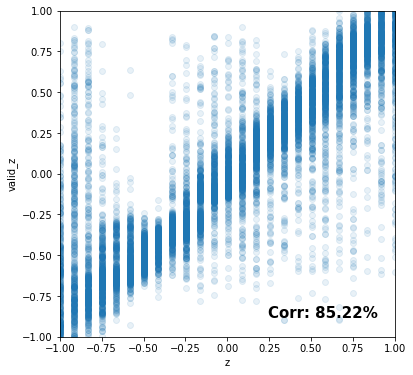

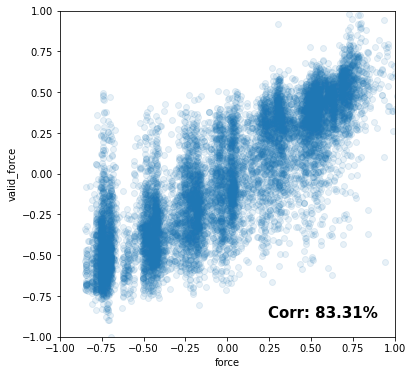

In [146]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1
output_dir = "myLearningData/savefig"  # 저장할 폴더 이름

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['z', 'force']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-1, 1)  # x축 범위 설정
    plt.ylim(-1, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()
